# Tutorial for BilinearModels package

## Introduction

Generalized bilinear models (GBMs) are a flexible extension of generalized linear models (GLMs) to include latent factors as well as row covariates, column covariates, and interactions to analyze matrix data (Choulakian, 1996; Miller and Carter, 2020).

This tutorial shows how to use the [BilinearModels.jl](https://github.com/jwmi/BilinearModels.jl) Julia package to perform estimation and inference in negative binomial GBMs for count data.  Please cite [Miller and Carter (2020)](#references) if you use the BilinearModels.jl package for research leading to a publication.

In a GBM, the data matrix $Y = (Y_{i j})\in\mathbb{R}^{I\times J}$ is modeled by parametrizing the mean $\mathrm{E}(Y)$ such that

$$ g(\mathrm{E}(Y)) = X A^\texttt{T} + B Z^\texttt{T} + X C Z^\texttt{T} + U D V^\texttt{T} $$

where $g$ is a a link function that is applied element-wise. The "bilinear" part $U D V^\texttt{T}$ is a rank $M$ matrix that captures latent effects due, for example, to unobserved covariates such as batch.  The BilinearModels.jl package currently uses a negative binomial outcome with log link, $g(\mu) = \log(\mu)$, specifically,

$$ Y_{i j} \sim \mathrm{NegBin}(\mu_{i j}, r_{i j}) $$

where $\mu_{i j} = \mathrm{E}(Y_{i j})$ is the mean and $1/r_{i j}$ is the dispersion, which we parametrize as $1/r_{i j} = \exp(s_i+t_j+\omega)$.  See [Miller and Carter (2020)](#references) for details.

<!-- <br><center><img src="https://github.com/jwmi/BilinearModelsExamples/raw/main/tutorial/figures/model-g.png" width="800"></center> -->

<br>
<div>
<!-- <img src="figures/model-g.png" align="center" width="800"/> -->
<img src="https://github.com/jwmi/BilinearModelsExamples/raw/main/tutorial/figures/model-g.png" align="center" width="800"/>
</div>

The package provides two main functions: `fit` and `infer`.  The `fit` function takes $Y$, $X$, $Z$, and $M$ as inputs, and returns estimates of all the parameters ($A$, $B$, $C$, $D$, $U$, $V$, $S$, $T$, and $\omega$).  The `infer` function takes $Y$, $X$, $Z$, and the parameter estimates as inputs, and returns approximate standard errors.


***
## Setup

### Installing BilinearModels.jl package

First, download and install [Julia](https://julialang.org/).  Start Julia and enter the following commands at the `julia>` prompt to install the [BilinearModels.jl](https://github.com/jwmi/BilinearModels.jl) package:

In [ ]:
using Pkg
Pkg.add(url="https://github.com/jwmi/BilinearModels.jl")

In [2]:
using BilinearModels

As a quick test to make sure things are working, try this:

In [3]:
Y = [1 2 3; 4 5 6; 7 8 0]
I,J = size(Y)
X = ones(I,1)
Z = ones(J,1)
A,B,C,D,U,V,S,T,omega,logp = BilinearModels.fit(Y,X,Z,0)
A

iteration 1: logp = -32.181561516520645
iteration 2: logp = -32.06094964489715
iteration 3: logp = -32.02450562203871
iteration 4: logp = -32.00936718102702
iteration 5: logp = -32.002571675212614
iteration 6: logp = -31.999367910889188
iteration 7: logp = -31.997817594791158
iteration 8: logp = -31.997057070632096
iteration 9: logp = -31.99668136745074
iteration 10: logp = -31.996495098807483
iteration 11: logp = -31.996402577578284
iteration 12: logp = -31.996356577164565
iteration 13: logp = -31.99633369482534
Finished.


3×1 Array{Float64,2}:
 -0.11118582286764742
  0.11506609564808493
 -0.0038802727804375103

### Installing other packages for tutorial

We will also use some other Julia packages in this tutorial.  To install these, do:

In [5]:
using Pkg
Pkg.add(["Statistics","CSV","RData","GLM","PyPlot"])

  Resolving package versions...
No Changes to `C:\Users\jwmil\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\jwmil\.julia\environments\v1.5\Manifest.toml`


### Loading example data

As a running example, we will use 412 RNA-seq samples from heart tissue provided by the [Recount2 project](https://jhubiostatistics.shinyapps.io/recount/) (Collado-Torres et al., 2017), originally collected as part of the Genotype-Tissue Expression (GTEx) project (Melé et al., 2015).

Download the following files to a folder on your computer:
- [Sample information file (344 KB)](https://github.com/jwmi/BilinearModelsExamples/raw/main/tutorial/gtex_sample_info-heart.txt)
- [Gene information file (2 MB)](https://github.com/jwmi/BilinearModelsExamples/raw/main/tutorial/gtex_gene_info-heart.txt)
- [Data file (15.7 MB)](https://github.com/jwmi/BilinearModelsExamples/raw/main/tutorial/gtex_data-heart.rda)
- [Miscellaneous helper functions](https://github.com/jwmi/BilinearModelsExamples/raw/main/tutorial/helper.jl)

Then, to load these data:

In [8]:
cd("C:\\Users\\jwmil\\gdrive\\BilinearModelsExamples\\tutorial")  # change directory to the location of these data files and helper.jl

include("helper.jl")  # load helper functions into Julia

Y = load("gtex_data-heart.rda")["counts"]  # load data matrix

gene_info = CSV.read("gtex_gene_info-heart.tsv"; delim='\t')  # load gene information file

sample_info = CSV.read("gtex_sample_info-heart.tsv"; delim='\t')  # load sample information file

I,J = size(Y)  # dimensions of data matrix

(20088, 412)

***


## Simple normalization

GBMs can be used for a wide range of tasks.  We first illustrate performing a simple normalization.
Count data are often preprocessed using a transformation such as $\log(Y_{i j}+1)$ and standardizing the rows and columns.
Instead, a model-based approach to normalizing count matrices is to use a negative binomial outcome model with

$$ \log(\mathrm{E}(Y_{i j})) = a_{j 1} + b_{i 1} + c_{1 1}, $$

which is a special case of a GBM.  The residuals from this model can be used for downstream analyses such as visualization with principal components analysis (PCA).

We illustrate on the GTEx heart data.  This special case is obtained by defining $X$, $Z$, and $M$ as follows.

In [15]:
X = ones(I,1)  # feature covariate matrix is a column of ones (i.e., intercepts only)
Z = ones(J,1)  # sample covariate matrix is a column of ones (i.e., intercepts only)
M = 0;         # no latent factors

To estimate the model parameters and compute the residuals, run:

In [17]:
A,B,C,D,U,V,S,T,omega,logp = BilinearModels.fit(Y,X,Z,M);  # fit the model

max step size enforced in S[i] update for one or more i.
max_step enforced in A[j,:] update for one or more j.
max step size enforced in S[i] update for one or more i.
iteration 1: logp = -4.608420742165705e7
iteration 2: logp = -4.601634813863698e7
iteration 3: logp = -4.600170494856905e7
iteration 4: logp = -4.599710814322703e7
iteration 5: logp = -4.599625286131605e7
iteration 6: logp = -4.5996207168753944e7
Finished.


In [20]:
Eps,Sigma = BilinearModels.residuals(Y,X,Z,A,B,C,D,U,V,S,T,omega);  # compute the residuals

In [30]:
Eps   # residuals (in log space)

20088×412 Array{Float64,2}:
 -0.265878   -0.222579     0.158723   …  -0.261669    0.149624   -0.285064
 -0.238001    0.038972    -1.92932       -1.6996     -0.429321    0.324711
 -0.0818612   0.00095037  -0.523208      -0.160458   -0.0675861   0.0819674
  0.107937    0.0598756   -0.153179      -0.0577972  -0.182423   -0.0767797
  0.0833096   0.0436139    0.132263       0.171293   -0.175273   -0.180144
 -0.69683     0.156707     0.79235    …  -0.278818    0.143196   -0.311216
 -2.23581    -1.79352      1.21497        0.87519    -0.106189   -2.32378
  0.2872      0.401399    -0.263188      -0.456907    0.100576    0.172459
  0.388704    0.107792    -0.220943      -0.246633    0.0818593   0.229746
 -0.13166     0.0592329    0.28131        0.231451   -0.0772693  -0.234834
  0.0290624  -0.0114029    0.261282   …  -0.430471   -0.653082   -0.466833
  0.314654    0.406307    -0.599261      -0.794029   -0.393816    0.228677
 -0.212182   -0.216112    -0.330861       0.236213    0.168179   -0.026

The residuals can be visualized using PCA. In this data, there are two clear clusters of samples, corresponding to subtissue type ("Heart - Atrial Appendage" and "Heart - Left Ventricle").

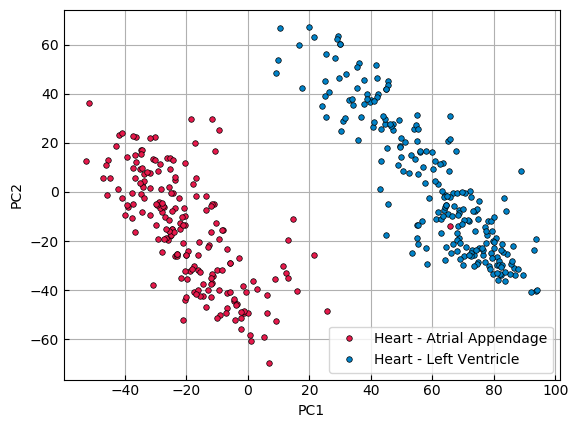

In [34]:
figure(1); clf(); grid(true)
scores = pcaplot(Eps',sample_info[!,:smtsd]; ms=4, mec="k")
legend();

For comparison, running PCA on the log-transformed TPMs does not appear to be as clean:

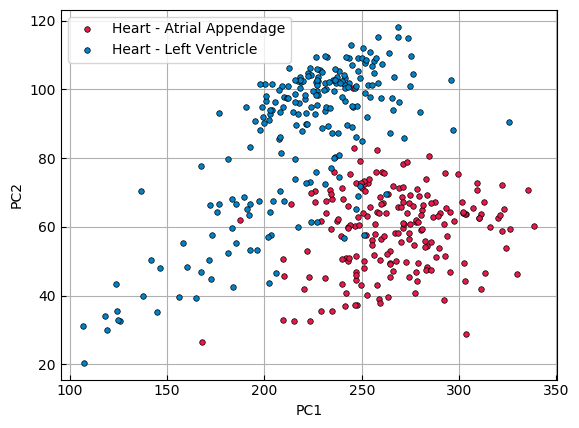

In [35]:
# Compute standard normalizations for comparison
RPM, RPKM, TPM = standard_normalizations(Y, gene_info[!,:seq_len])

figure(2); clf(); grid(true)
pcaplot(log.(TPM.+1)',sample_info[!,:smtsd]; ms=4, mec="k")
legend();

To explore relationships in the data, it is useful to color the PCA plot using a variety of covariates.  We illustrate coloring by two discrete covariates (`smcenter` = sample collection center, and `sex`) and two continuous covariates (`age_numeric` = age coded as range midpoint, and `smrin` = RIN number).

In practice, one must be careful to avoid finding spurious relationships, so in practice we recommend splitting the data into an exploratory subset and a testing subset (e.g., see Miller and Carter, 2020).

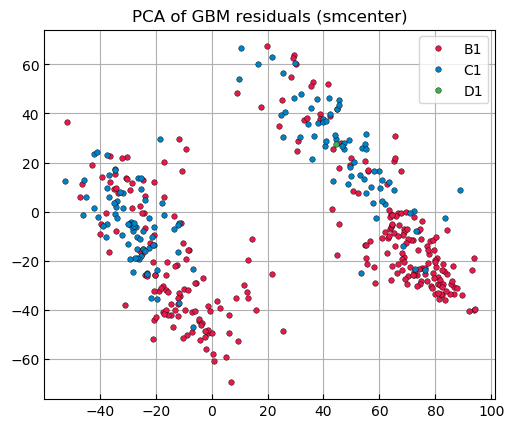

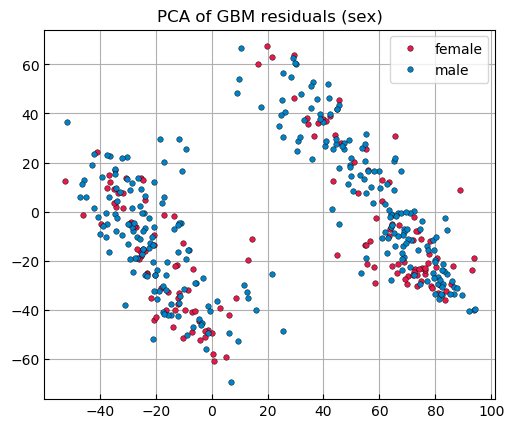

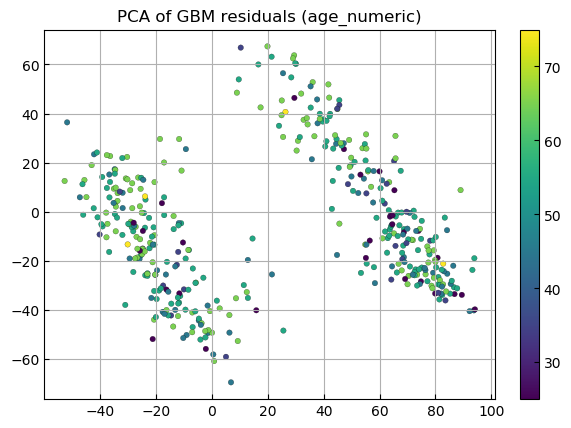

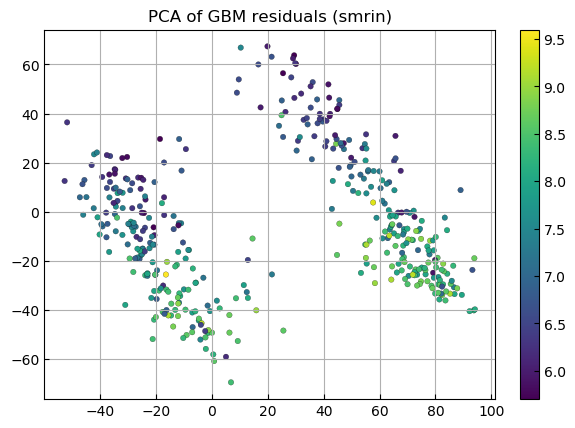

In [37]:
# Visualize association with sample covariates
colorbycategory = [:smcenter,:sex]
colorbynumeric = [:age_numeric,:smrin]
fignum = 0
for colorby in [colorbycategory; colorbynumeric]
    figure(fignum+=1); clf(); grid(true)
    cvalue = sample_info[!,colorby]
    if colorby in colorbycategory
        plotgroups(scores[:,1], scores[:,2], string.(cvalue); ms=4, mec="k", mew=0.3)
        subplots_adjust(right=0.83)
        legend()
    else
        scatter(scores[:,1], scores[:,2], 16, c=cvalue; edgecolor="k", linewidth=0.15)
        subplots_adjust(right=0.9)
        colorbar(fraction=0.04)
    end
    title("PCA of GBM residuals ($(string(colorby)))")
end

<a id='references'></a>

## References

Choulakian, V. **Generalized bilinear models.** Psychometrika, 61(2):271–283, 1996.

Collado-Torres, L., Nellore, A., Kammers, K., Ellis, S. E., Taub, M. A., Hansen, K. D., Jaffe, A. E., Langmead, B., and Leek, J. T. **Reproducible RNA-seq analysis using recount2.** Nature Biotechnology, 35(4):319–321, 2017.

Melé, M., Ferreira, P. G., Reverter, F., DeLuca, D. S., Monlong, J., Sammeth, M., Young, T. R., Goldmann, J. M., Pervouchine, D. D., Sullivan, T. J., et al. **The human transcriptome across tissues and individuals.** Science, 348(6235):660–665, 2015.

Miller, J. W. and Carter, S. L.  **Inference in generalized bilinear models.** [arXiv preprint: arXiv2010.04896](https://arxiv.org/abs/2010.04896), 2020.

<br><br><br><br><br>